# Pre-processing for Challenge 1b
This script creates task-specific features and labels for drug response prediction.
The datasets used for this challenge come from the **Sanger Genomics of Drug Sensitivity in Cancer (GDSC1000)** resource, a high-throughput pharmacogenomic screen of 255 anti-cancer drugs administered to each of 990 cancer cell lines encompassing 30 tissues.


In [33]:
!pip install mygene

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re

In [4]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        print('Load network', file_name)
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            gene1, gene2 = line[0], line[1]
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map
                             
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=f57ee7c981b7e61131135089afb402eee8db669f3b61697ce49094b0c4daa21b
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [6]:
##### Sanger Genomics of Drug Sensitivity in Cancer (GDSC) dataset from the Cancer Genome Project
# The data are freely available under the license agreement described on their website: https://www.cancerrxgene.org/downloads
# The required files can be downloaded by connecting to the FTP server 'ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/'

in_dir = '/content/drive/MyDrive/MBP1413H/tcrp_model/data/input/original/'
out_dir = '/content/drive/MyDrive/MBP1413H/tcrp_model/data/output/' 
feature_folder = out_dir + 'feature/'

# GENE EXPRESSION DATASET: RMA-normalised basal expression profiles (17,737 genes) for all the cell-lines
# Download URL: ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/release-6.0/sanger1018_brainarray_ensemblgene_rma.txt.gz
exp_data_file = in_dir + 'Cell_line_RMA_proc_basalExp.txt'

# DRUG RESPONSE DATASET: Drug response (IC50, AUC, max./min. concentration, etc.) 
# Download URL: ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx
drug_cell_line_file = in_dir + 'v17_fitted_dose_response.csv'

# MUTATION DATASET: Small DNA variants (single-nucleotide variants, insertions, deletions) observed in the coding regions of each cell line
# Download URL: ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/release-6.0/WES_variants.xlsx
mutation_data_file = in_dir + 'WES_variants.csv'

# CELL LINE DESCRIPTORS DATASET: Detailed description of each of 1,001 tumor cell lines (representing 30 tissues)
# Download URL: ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/release-6.0/Cell_Lines_Details.xlsx
cell_line_detail_file = in_dir + 'Cell_Lines_Details.csv'

# DRUG DESCRIPTORS DATASET: Detailed description of each of 265 anti-cancer drugs
# Download URL: ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/release-6.0/Screened_Compounds.xlsx
drugs_legend_file = in_dir + 'Screened_Compounds.csv'

# DRUG TARGET AND PATHWAY DATASET: 
# Data adapted from Table S1G of the original GDSC1000 paper
drug_target_file = in_dir + 'drug_target_list.csv'

gene_name_file = in_dir + 'HUGO_protein-coding_gene.tsv'

# PROTEIN-PROTEIN INTERACTION (PPI) DATASETS: PPI data from the InBioMap, PathwayCommons and CORUM databases
inbiomap_file = in_dir + 'InBioMap_Symbol.sif'
pathwaycomm_file = in_dir + 'PathwayCommons9.All.hgnc.sif'
corum_file = in_dir + 'allComplexes.txt'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

In [7]:
exp_df = pd.read_csv(exp_data_file, sep=',', index_col=0) # changed sep='\t' to sep=','
exp_df = exp_df.T[1:]
exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
exp_df = exp_df.drop('NO_GENE_NAME',axis=1,errors='ignore') # added errors='ignore'
def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

exp_df = exp_df.T[1:] # added this line of code

exp_df.index = exp_df.index.map(stripNumber)
exp_df = exp_df.groupby(level=0).first()

exp_gene_list = list(exp_df.columns) # added this line of code
exp_cell_line_list = list(exp_df.index.unique()) # added this line of code
exp_df

,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,LINC00514,OR1D5,ZNF234,MYH4,LINC00526,PPY2,KRT18P55,POLRMTP1,UBL5P2,TBC1D3P5
683665,2.982254,10.235491,4.856061,4.078870,9.116236,3.658590,6.145475,5.042464,5.438402,3.336360,...,3.103752,3.724013,3.981948,2.823245,5.866047,3.095716,3.274367,3.056214,9.446305,3.530871
683667,2.753253,9.960137,4.351073,3.716740,3.222277,8.221606,3.823474,4.756228,5.805642,3.201135,...,3.175476,3.779354,4.504481,2.690651,3.347520,3.230713,3.102091,3.169188,9.810430,3.266915
684052,2.890533,9.922489,4.125088,3.678987,3.096576,3.588391,4.809305,4.951782,5.089165,3.559245,...,3.299300,3.762301,4.177345,2.499803,5.054260,3.003521,3.068187,3.135479,9.073222,3.098364
684055,3.091473,9.992487,4.572198,3.333385,3.320793,3.159487,3.515105,5.446361,5.348338,3.291030,...,3.251885,2.929491,4.702208,2.489674,5.097089,3.114744,3.119647,3.194925,9.013220,3.074187
684057,2.824687,10.015884,4.749715,3.839433,3.142754,5.329830,3.272124,5.538055,6.428482,2.980635,...,3.081750,3.226083,4.666295,2.491254,6.261573,3.031862,3.322455,2.813440,8.893197,3.266184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660036,2.640900,9.463400,4.039697,3.854522,3.212820,3.369225,8.969264,6.660734,4.942390,3.569882,...,6.654799,3.734381,4.158913,2.849266,4.772469,3.101758,3.662190,3.329809,9.491964,3.317055
1674021,3.157319,10.153141,3.768090,3.502940,3.219493,3.353777,7.774275,6.146783,5.429215,3.251371,...,8.123459,3.467924,3.862499,2.835317,3.329585,3.193906,4.152130,3.332182,8.826412,3.852447
1723793,2.759430,10.381303,4.596494,4.101198,3.442188,4.684189,8.540689,5.466290,5.798390,3.591857,...,3.122087,3.409170,3.989737,2.488525,4.011168,2.934818,3.472314,3.122506,9.534718,3.543271
1723794,2.892534,10.203625,3.867890,3.962809,3.562039,3.198608,9.053622,5.309724,5.795402,3.489791,...,3.177008,3.247534,4.005281,2.484837,4.825418,2.989489,3.139941,3.128112,10.346289,3.192360


In [8]:
maf = pd.read_csv(mutation_data_file, sep=',', index_col=0).fillna(0) # changed sep='\t' to sep=','
mutation_df = maf.groupby(['COSMIC_ID', 'Gene']).size().unstack().fillna(0).clip(upper=1) # changed clip.upper(1) to clip(upper=1)
mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())

print(len(mutation_cell_line_list), len(mutation_gene_list))

mutation_df

1001 19100


Gene,A1BG,A1CF,A2M,A2ML1,A4D226,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hCG_17324,hsa-mir-4763
COSMIC_ID,,,,,,,,,,,,,,,,,,,,,
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
683667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1660035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1660036,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
file_handle = open(drug_target_file)

drug_target_map = {}
drug_target_list = []

for line in file_handle:
    
    drug, target_list_str = line.rstrip().split(',',1) #changed split('|') to split(',',1)
    drug = drug.strip()
    
    drug_target_map[drug] = []
    
    if ',' not in target_list_str:
        drug_target_map[drug].append(target_list_str.strip())
        drug_target_list.append(target_list_str.strip())
    else:
        target_list = target_list_str.replace('"','').split(',') # added replace('"','')
        for target in target_list:
            drug_target_map[drug].append(target.strip())
            drug_target_list.append(target.strip())

print(len(drug_target_list))
print(drug_target_map)

412
{'Erlotinib': ['EGFR'], 'Rapamycin': ['MTOR'], 'Sunitinib': ['PDGFRA', 'PDGFRB', 'KDR', 'KIT', 'FLT3'], 'PHA-665752': ['MET'], 'MG-132': ['Proteasome'], 'Paclitaxel': ['TUBB1', 'BCL2', 'MAP4', 'MAP2', 'MAPT', 'NR1I2'], 'Cyclopamine': ['SMO'], 'AZ628': ['BRAF'], 'Sorafenib': ['PDGFRA', 'PDGFRB', 'KDR', 'KIT', 'FLT3'], 'VX-680': ['AURKA', 'AURKB', 'AURKC', 'FLT3', 'ABL1', 'JAK2'], 'Imatinib': ['ABL', 'KIT', 'PDGFR'], 'NVP-TAE684': ['ALK'], 'Crizotinib': ['MET', 'ALK'], 'AZD-0530': ['SRC', 'ABL1'], 'S-Trityl-L-cysteine': ['KIF11'], 'Z-LLNle-CHO': ['g-secretase'], 'Dasatinib': ['ABL', 'SRC', 'KIT', 'PDGFR'], 'GNF-2': ['ABL [T315I]'], 'CGP-60474': ['CDK1', 'CDK2', 'CDK5', 'CDK7', 'CDK9'], 'CGP-082996': ['CDK4'], 'A-770041': ['SRC family'], 'WH-4-023': ['SRC family', 'ABL'], 'WZ-1-84': ['BMX'], 'BI-2536': ['PLK1', 'PLK2', 'PLK3'], 'BMS-536924': ['IGF1R'], 'BMS-509744': ['ITK'], 'CMK': ['RSK'], 'Pyrimethamine': ['Dihydrofolate reductase (DHFR)'], 'JW-7-52-1': ['MTOR'], 'A-443654': ['AKT1'

In [10]:
drugs_legend = pd.read_csv(drugs_legend_file, sep=',', index_col=0) # changed sep='\t' to sep=','

drug2id_mapping = {}

for index in list(drugs_legend.index) :
    drug_name = drugs_legend.loc[index,'Drug Name'] # changed 'DRUG NAME' to 'Drug Name'
    drug2id_mapping[ drug_name ] = index

drug2id_mapping

{'Erlotinib': 1,
 'Rapamycin': 3,
 'Sunitinib': 5,
 'PHA-665752': 6,
 'MG-132': 9,
 'Paclitaxel': 11,
 'Cyclopamine': 17,
 'AZ628': 29,
 'Sorafenib': 30,
 'Tozasertib': 32,
 'Imatinib': 34,
 'NVP-TAE684': 35,
 'Crizotinib': 37,
 'Saracatinib': 38,
 'S-Trityl-L-cysteine': 41,
 'Z-LLNle-CHO': 45,
 'Dasatinib': 51,
 'GNF-2': 52,
 'CGP-60474': 53,
 'CGP-082996': 54,
 'A-770041': 55,
 'WH-4-023': 56,
 'WZ-1-84': 59,
 'BI-2536': 60,
 'BMS-536924': 1091,
 'BMS-509744': 63,
 'CMK': 64,
 'Pyrimethamine': 71,
 'JW-7-52-1': 83,
 'A-443654': 86,
 'GW843682X': 87,
 'Entinostat': 88,
 'Parthenolide': 89,
 'GSK319347A': 91,
 'TGX221': 94,
 'Bortezomib': 104,
 'XMD8-85': 106,
 'Seliciclib': 110,
 'Salubrinal': 111,
 'Lapatinib': 119,
 'GSK269962A': 1192,
 'Doxorubicin': 133,
 'Etoposide': 134,
 'Gemcitabine': 135,
 'Mitomycin-C': 136,
 'Vinorelbine': 140,
 'NSC-87877': 147,
 'Bicalutamide': 1502,
 'QS11': 151,
 'CP466722': 152,
 'Midostaurin': 153,
 'CHIR-99021': 1241,
 'Ponatinib': 155,
 'AZD6482': 1

In [11]:
valid_gene_list = list(set(drug_target_list) | set(exp_gene_list) | set(mutation_gene_list))

In [12]:
network_list = [inbiomap_file,pathwaycomm_file]
gene_neighbor_map = load_network(network_list, valid_gene_list) # this takes about 20 minutes to run

Load network /content/drive/MyDrive/MBP1413H/tcrp_model/data/input/original/InBioMap_Symbol.sif
Load network /content/drive/MyDrive/MBP1413H/tcrp_model/data/input/original/PathwayCommons9.All.hgnc.sif


In [13]:
gene_name_df = pd.read_table(gene_name_file, index_col=25, sep='\t', low_memory=False)

In [14]:
gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    #print(uniprot_gene)
    if isinstance(uniprot_gene, type('aaa')) == False:
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']

In [15]:
corum_df = pd.read_table(corum_file, index_col=0)

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

print(len(uniprot_gene_set), 'genes')

query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
print('Need to query', len(query_gene_set))

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']
        
print(len(not_found_gene_list), 'symbol name not found', len(gene_name_map))

3674 genes
Need to query 43


26 symbol name not found 19072


In [16]:
for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

## Task-specific features
Task-specific features were constructed for each drug by selecting genes having PPI or mRNA co-expression relationships (|r| > 0.4) with the documented drug targets. For drugs with multiple targets, we included all PPI/co-expressed neighbors of these targets. Furthremore, we removed gene expression features for which the s.d.s fell into the lowest 10% over all genes and excluded genes with <10 somatic mutations across cell lines.

Somatic mutations and mRNA expression levels of the remaining selected genes were applied to construct the input feature vector for each cell line.

In [35]:
!python -V

Python 3.9.16


In [17]:
gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print(gene1, 'not in itself?', P[i,i]) # this also takes about 15 minutes to run

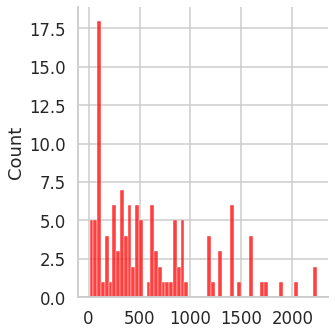

In [18]:
drug_feature_list = []
drug_neighbor_map = {}
selected_drug_list = []

for drug, target_list in drug_target_map.items():
    
    drug_neighbor_map[drug] = set()
    
    for gene in target_list:
        
        if gene not in gene_exp_neighbor_map and gene not in gene_neighbor_map:
            continue
    
        if gene in gene_exp_neighbor_map:
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_exp_neighbor_map[gene]
            
        if gene in gene_neighbor_map:
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_neighbor_map[gene]
    
    if len(drug_neighbor_map[drug]) != 0:
        selected_drug_list.append(drug)
        drug_feature_list.append( len(drug_neighbor_map[drug]) )

sns.set_style("whitegrid")
sns.set_context("talk")
#sns.distplot(drug_feature_list,color='r',bins=60,kde=False,norm_hist=False)
sns.displot(drug_feature_list,color='r',bins=60)

In [19]:
drugs = pd.read_csv(drug_cell_line_file, sep=',',index_col=2) # changed sep='\t' to sep=','
drugs_cell_line_list = list(drugs.index.unique())
print(len(drugs_cell_line_list))
drugs

1074


,DATASET_VERSION,IC50_RESULTS_ID,DRUG_ID,MAX_CONC_MICROMOLAR,LN_IC50,AUC,RMSE
COSMIC_ID,,,,,,,
924100,17,335,1026,1.00,0.717722,0.899410,0.105665
924100,17,336,1028,2.00,2.664100,0.957206,0.178243
924100,17,337,1029,2.00,3.336828,0.973893,0.079845
924100,17,338,1030,10.00,5.164909,0.977844,0.094228
924100,17,339,1031,0.20,-4.325309,0.508180,0.090478
...,...,...,...,...,...,...,...
909907,17,226218,1053,4.00,1.282224,0.809102,0.157131
909907,17,226219,1054,4.00,5.480756,0.982976,0.027090
909907,17,226220,1057,0.25,-0.138981,0.904217,0.031997


In [20]:
cell_line_list = list(set(drugs_cell_line_list)&set(exp_cell_line_list)&set(mutation_cell_line_list) )
print(len(cell_line_list))

961


In [21]:
cell_line_legend = pd.read_csv(cell_line_detail_file, sep=',', index_col=1) # changed sep='\t' to sep=','
#print cell_line_legend

tissue_map = {}

for cell_line in cell_line_list:
    
    tissue = cell_line_legend.loc[cell_line,'Site']
    
    if tissue not in tissue_map:
        tissue_map[tissue] = []
        
    tissue_map[tissue].append(cell_line)

large_tissue_number = 0
for tissue, cell_line in tissue_map.items():
    
    if len(cell_line) >= 15: # number of "held-out" tissues for the few-shot phase
        large_tissue_number += 1
    
    print(tissue, len(cell_line))

print('How many tissues', len(tissue_map))
print('Large tissues', large_tissue_number)

'''
file_handle = open(out_dir + "sanger_tissue_cell_line_list.pkl","wb")
pickle.dump(tissue_map,file_handle)
file_handle.close()
'''

haematopoietic_and_lymphoid_tissue 163
central_nervous_system 56
stomach 28
bone 40
pancreas 32
large_intestine 48
lung 169
soft_tissue 22
urinary_tract 19
autonomic_ganglia 29
oesophagus 35
upper_aerodigestive_tract 42
ovary 41
breast 49
cervix 13
endometrium 11
thyroid 15
skin 55
liver 16
adrenal_gland 1
vulva 3
prostate 7
biliary_tract 5
kidney 31
salivary_gland 2
pleura 21
NS 3
testis 2
placenta 2
small_intestine 1
How many tissues 30
Large tissues 19


'\nfile_handle = open(out_dir + "sanger_tissue_cell_line_list.pkl","wb")\npickle.dump(tissue_map,file_handle)\nfile_handle.close()\n'

In [22]:
new_data_file = ''

print(mutation_df.shape, exp_df.shape)

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

print(np.sum(exp_stdev > exp_perc), np.sum(mut_sum > 5))

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]


rename_selected_drug_list = []

for drug in selected_drug_list:
    
    if drug not in drug2id_mapping:
        print('drug name wrong', drug)
        continue # skip
        #sys.exit(1)
    
    cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == drug2id_mapping[drug]]
    
    feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
    feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
    
    if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
        continue
    
    feature_description = []
    
    drug_tissue_map = {}
    
    drug = drug.replace(' ','_')
    
    rename_selected_drug_list.append(drug)
    
    print(drug)
    if drug == 'Nutlin-3a_(-)':
        drug = 'Nutlin-3a'
    
    drug_folder = out_dir + 'drug_feature/' + drug + '/'
    if not os.path.exists(drug_folder):
        os.makedirs(drug_folder)
        
    print('Generate features', drug)
    
    for tissue, tissue_cell_line_list in tissue_map.items():
        
        drug_specific_cell_line = list(set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )) # changed to list
        
        drug_tissue_map[tissue] = drug_specific_cell_line
        
        feature_list = []
        
        if len(feature_exp_gene_list) != 0:
            feature_list.append( new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values )
            for gene in feature_exp_gene_list:
                feature_description.append(gene+'_expression')
        
        if len(feature_mut_gene_list) != 0:
            feature_list.append( mutation_df.loc[ drug_specific_cell_line, feature_mut_gene_list ].values )
            for gene in feature_mut_gene_list:
                feature_description.append(gene+'_mutation')
            
        feature = np.concatenate(feature_list, axis=1)
        
        label = cell_line_drug_matrix.loc[ drug_specific_cell_line,'LN_IC50'].values
    
        print(feature.shape, label.shape)
     
        np.save(drug_folder + tissue + '_' + drug + '_feature.npy', feature )
        np.save(drug_folder + tissue + '_' + drug + '_label.npy', label)
        np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))
        
    cell_list_folder = out_dir + 'cell_line_lists/'
    if not os.path.exists(cell_list_folder):
        os.makedirs(cell_list_folder)
        
    file_handle = open(cell_list_folder + drug + '_tissue_cell_line_list.pkl',"wb")
    pickle.dump(drug_tissue_map,file_handle)
    file_handle.close()
    
file_handle = open(out_dir + 'rename_selected_drug_list', 'w')
for drug in rename_selected_drug_list:
    file_handle.writelines(drug+ '\n')
file_handle.close()


(1001, 19100) (1013, 17418)
15676 16794
Erlotinib
Generate features Erlotinib
(134, 2590) (134,)
(27, 2590) (27,)
(9, 2590) (9,)
(20, 2590) (20,)
(2, 2590) (2,)
(15, 2590) (15,)
(54, 2590) (54,)
(6, 2590) (6,)
(2, 2590) (2,)
(22, 2590) (22,)
(8, 2590) (8,)
(4, 2590) (4,)
(4, 2590) (4,)
(12, 2590) (12,)
(0, 2590) (0,)
(2, 2590) (2,)
(2, 2590) (2,)
(18, 2590) (18,)
(0, 2590) (0,)
(0, 2590) (0,)
(2, 2590) (2,)
(2, 2590) (2,)
(2, 2590) (2,)
(8, 2590) (8,)
(1, 2590) (1,)
(2, 2590) (2,)
(1, 2590) (1,)
(2, 2590) (2,)
(0, 2590) (0,)
(1, 2590) (1,)
Rapamycin
Generate features Rapamycin
(132, 600) (132,)
(19, 600) (19,)
(7, 600) (7,)
(21, 600) (21,)
(1, 600) (1,)
(13, 600) (13,)
(60, 600) (60,)
(6, 600) (6,)
(2, 600) (2,)
(24, 600) (24,)
(8, 600) (8,)
(4, 600) (4,)
(3, 600) (3,)
(14, 600) (14,)
(1, 600) (1,)
(3, 600) (3,)
(2, 600) (2,)
(15, 600) (15,)
(0, 600) (0,)
(0, 600) (0,)
(2, 600) (2,)
(2, 600) (2,)
(3, 600) (3,)
(5, 600) (5,)
(1, 600) (1,)
(3, 600) (3,)
(0, 600) (0,)
(2, 600) (2,)
(1, 60

In [23]:
len(drug_specific_cell_line)

1

In [24]:
len(drug_tissue_map['breast'])

47

In [25]:
import pickle

In [26]:
cell_line_loc = cell_list_folder
print(cell_line_loc)

/content/drive/MyDrive/MBP1413H/tcrp_model/data/output/cell_line_lists/


In [27]:
with open(cell_line_loc + 'BMS-754807_tissue_cell_line_list.pkl', 'rb') as f: 
    tmap= pickle.load(f)

In [28]:
tmap.keys()

dict_keys(['haematopoietic_and_lymphoid_tissue', 'central_nervous_system', 'stomach', 'bone', 'pancreas', 'large_intestine', 'lung', 'soft_tissue', 'urinary_tract', 'autonomic_ganglia', 'oesophagus', 'upper_aerodigestive_tract', 'ovary', 'breast', 'cervix', 'endometrium', 'thyroid', 'skin', 'liver', 'adrenal_gland', 'vulva', 'prostate', 'biliary_tract', 'kidney', 'salivary_gland', 'pleura', 'NS', 'testis', 'placenta', 'small_intestine'])

In [29]:
len(tmap['lung'])

151

In [30]:
f = np.load(out_dir + 'drug_feature/' + 'KU-55933/lung_KU-55933_feature.npy')

In [31]:
f.shape

(137, 780)